In [1]:
# Necessary imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from tensorflow import keras


C:\Users\USER\anaconda3\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Print TensorFlow version
print("TensorFlow Version:", tf.__version__)

# Check if GPU device is available
print("Is GPU available:", tf.test.is_gpu_available())

# List of available GPUs
print("List of GPUs:", tf.config.experimental.list_physical_devices('GPU'))

# Additional GPU information
if tf.config.experimental.list_physical_devices('GPU'):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        print("Name:", gpu.name, " Type:", gpu.device_type)

TensorFlow Version: 2.10.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True
List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Name: /physical_device:GPU:0  Type: GPU


In [3]:
# Load dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# Data preprocessing
IMG_SIZE = 224

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Normalize to [-1,1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# Batch and shuffle
BATCH_SIZE = 32
train_batches = train.shuffle(1000).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


In [4]:
# Initialize an empty set to store unique labels
unique_labels = set()

# Sample a subset of the dataset
for i, (_, label) in enumerate(raw_train.take(1000)):  # Replace `raw_train` with your dataset and 1000 with your sample size
    unique_labels.add(label.numpy())

# Count the number of unique labels (i.e., the number of classes)
num_classes = len(unique_labels)

print(f"The number of unique classes in the sample is: {num_classes}")
print(f"The unique classes in the sample are: {unique_labels}")


The number of unique classes in the sample is: 2
The unique classes in the sample are: {0, 1}


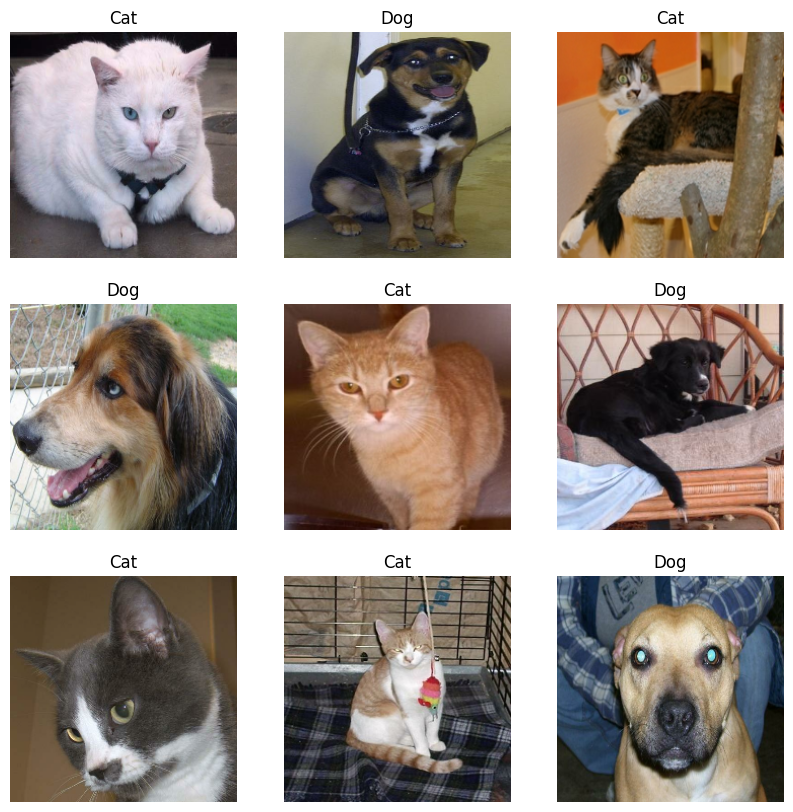

In [5]:
# Function to display images
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow((image_batch[n] + 1) / 2)  # Re-normalize to [0,1]
        plt.title('Dog' if label_batch[n]==1 else 'Cat')
        plt.axis('off')

# Displaying the images
for image_batch, label_batch in train_batches.take(1):
    show_batch(image_batch.numpy(), label_batch.numpy())


In [6]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=validation_batches
)

Epoch 1/10
582/582 [==============================] - 42s 66ms/step - loss: 0.6332 - accuracy: 0.6602 - val_loss: 0.5613 - val_accuracy: 0.7094
Epoch 2/10
582/582 [==============================] - 38s 65ms/step - loss: 0.4788 - accuracy: 0.7627 - val_loss: 0.4341 - val_accuracy: 0.8009
Epoch 3/10
582/582 [==============================] - 38s 64ms/step - loss: 0.3601 - accuracy: 0.8405 - val_loss: 0.4946 - val_accuracy: 0.8005
Epoch 4/10
582/582 [==============================] - 38s 65ms/step - loss: 0.2027 - accuracy: 0.9176 - val_loss: 0.7198 - val_accuracy: 0.7962
Epoch 5/10
582/582 [==============================] - 38s 65ms/step - loss: 0.0849 - accuracy: 0.9690 - val_loss: 0.9409 - val_accuracy: 0.7997
Epoch 6/10
582/582 [==============================] - 38s 65ms/step - loss: 0.0484 - accuracy: 0.9846 - val_loss: 0.9836 - val_accuracy: 0.7868
Epoch 7/10
582/582 [==============================] - 38s 65ms/step - loss: 0.0332 - accuracy: 0.9892 - val_loss: 1.0800 - val_accuracy:

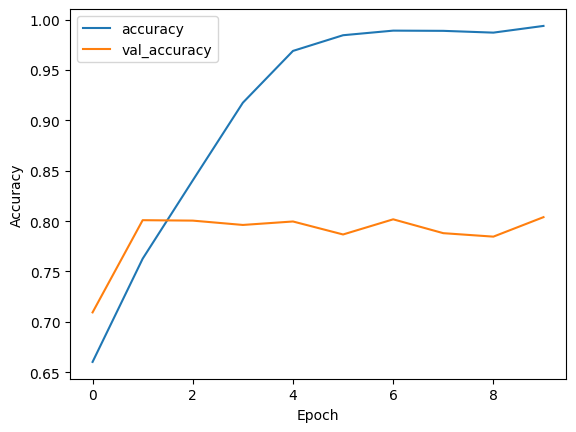

73/73 [==============================] - 2s 20ms/step - loss: 1.1231 - accuracy: 0.8001
Test accuracy: 80.01%
Test loss: 112.31%


In [8]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_batches)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

In [9]:
# Importing weights ans biases from a previous trained network
vgg = keras.applications.VGG16(weights='imagenet', include_top=True,)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# when working with multi class problems
# # Freeze all layers
# for layer in vgg.layers:
#     layer.trainable = False

# # Create new softmax layer
# new_classification_layer = Dense(num_classes, activation='softmax')

# # Create new model
# out = new_classification_layer(vgg.layers[-2].output)
# model_new = Model(inputs=vgg.input, outputs=out)

# # Display the model's architecture
# model_new.summary()

In [13]:
# Freeze all layers in the pre-trained model
for layer in vgg.layers:
    layer.trainable = False

# Create the new model
new_input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
new_output = vgg(new_input_layer)  # Use the VGG model for convolutional layers

# Flatten and add new fully connected layers
new_output = Flatten()(new_output)
new_output = Dense(4096, activation='relu', name='new_fc1')(new_output)
new_output = Dense(4096, activation='relu', name='new_fc2')(new_output)
new_output = Dense(1, activation='sigmoid', name='new_predictions')(new_output)  # 1 for binary problems

# Compile the new model
new_model = Model(inputs=new_input_layer, outputs=new_output)
new_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Train the new model
history2 = new_model.fit(train_batches,
                        epochs=10,
                        validation_data=validation_batches)


Epoch 1/10
582/582 [==============================] - 67s 108ms/step - loss: 0.2428 - accuracy: 0.8963 - val_loss: 0.1743 - val_accuracy: 0.9273
Epoch 2/10
582/582 [==============================] - 59s 101ms/step - loss: 0.1887 - accuracy: 0.9208 - val_loss: 0.1619 - val_accuracy: 0.9342
Epoch 3/10
582/582 [==============================] - 59s 100ms/step - loss: 0.1712 - accuracy: 0.9283 - val_loss: 0.2811 - val_accuracy: 0.8762
Epoch 4/10
582/582 [==============================] - 59s 100ms/step - loss: 0.1681 - accuracy: 0.9308 - val_loss: 0.1566 - val_accuracy: 0.9385
Epoch 5/10
582/582 [==============================] - 59s 101ms/step - loss: 0.1689 - accuracy: 0.9290 - val_loss: 0.1570 - val_accuracy: 0.9329
Epoch 6/10
582/582 [==============================] - 59s 101ms/step - loss: 0.1531 - accuracy: 0.9354 - val_loss: 0.1648 - val_accuracy: 0.9372
Epoch 7/10
582/582 [==============================] - 59s 101ms/step - loss: 0.1477 - accuracy: 0.9377 - val_loss: 0.1483 - val_ac

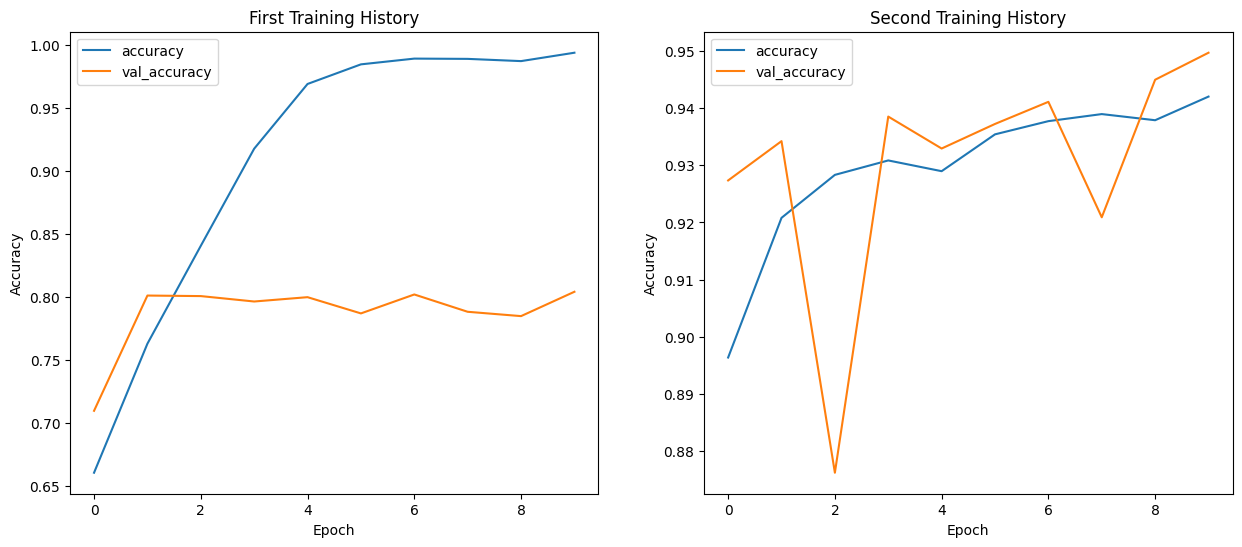

73/73 [==============================] - 5s 71ms/step - loss: 0.1222 - accuracy: 0.9467
Test accuracy: 94.67%
Test loss: 12.22%


In [16]:
# Plotting for comparing
# Plot training history

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot data on the first subplot
axes[0].plot(history.history['accuracy'], label='accuracy')
axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('First Training History')

# Plot data on the second subplot
axes[1].plot(history2.history['accuracy'], label='accuracy')
axes[1].plot(history2.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Second Training History')

# Show the plot
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = new_model.evaluate(test_batches)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

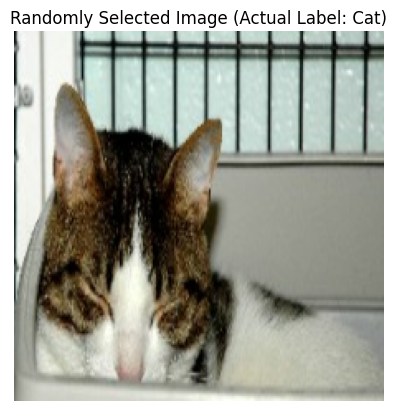

1/1 [==============================] - 1s 877ms/step
Actual label: Cat
Predicted label: Cat with probability 0.00038575363578274846


In [17]:
# Function to make a prediction on a single image
def predict_single_image(model, image, label, categories=['Cat', 'Dog']):
    # Expand dimensions for batch size and preprocess the image
    image = np.expand_dims(image, axis=0)
    
    # Make prediction
    probabilities = model.predict(image)
    
    # Get the class with the highest probability
    predicted_class_index = np.argmax(probabilities[0])
    
    # Get the name of the class
    predicted_class_name = categories[predicted_class_index]
    
    # Print the results
    print(f"Actual label: {categories[label]}")
    print(f"Predicted label: {predicted_class_name} with probability {np.max(probabilities[0])}")

# Take one batch of the test set
for image_batch, label_batch in test_batches.take(1):
    # Convert to numpy arrays
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    
    # Pick a random index
    random_idx = np.random.choice(image_batch.shape[0])
    
    # Get the corresponding image and label
    random_image = image_batch[random_idx]
    random_label = label_batch[random_idx]
    
    # Display the image
    plt.figure()
    plt.imshow((random_image + 1) / 2)  # Denormalize the image
    plt.title(f'Randomly Selected Image (Actual Label: {["Cat", "Dog"][random_label]})')
    plt.axis('off')
    plt.show()
    
    # Make prediction
    predict_single_image(new_model, random_image, random_label)
